In [1]:
import utils
import keras
import model01
import datasets
import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [75]:
# FILENAME = './output/MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5-200-0.6926.hdf5'
#FILENAME = './output/MLPModel01_20170310_0845_LA1_F99_C2_L100_100_100_DO0.5-200-0.6890.hdf5'
#FILENAME = './output/MLPModel01_20170412_0617_LA1_F99_C2_L100_100_100_DO0.5-065-0.6920.hdf5'
#FILENAME = './output/MLPModel01_20170412_0824_LA1_F99_C2_L100_100_100_DO0.5-035-0.6923.hdf5'
#FILENAME = './output/MLPModel01_20170412_0824_LA1_F99_C2_L100_100_100_DO0.5-055-0.6922.hdf5'
#FILENAME = './output/MLPModel01_20170412_0824_LA1_F99_C2_L100_100_100_DO0.5-125-0.6920.hdf5'
FILENAME = './output/MLPModel01_20170412_0824_LA1_F99_C2_L100_100_100_DO0.5-200-0.6918.hdf5'

In [76]:
#model = model01.MLPModel01.load(FILENAME)
# infers model description file from this filename
# loads model training history + weights from this specific file

In [77]:
model = keras.models.load_model(FILENAME)

In [78]:
#pc = model01.ProgressCallback.load('MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5')
#pc = model01.ProgressCallback.load('MLPModel01_20170310_0845_LA1_F99_C2_L100_100_100_DO0.5')
#pc = model01.ProgressCallback.load('MLPModel01_20170412_0617_LA1_F99_C2_L100_100_100_DO0.5')
pc = model01.ProgressCallback.load('MLPModel01_20170412_0824_LA1_F99_C2_L100_100_100_DO0.5')


loading from file: ./output/MLPModel01_20170412_0824_LA1_F99_C2_L100_100_100_DO0.5.npz


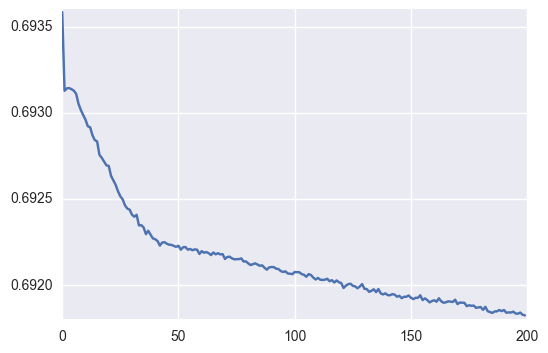

In [79]:
#plt.plot(pc.train_losses)
plt.plot(pc.validation_losses)

In [82]:
# load test dataset
lookahead=1
dataset = 'DS3'
window=25
sym='EURUSD'
year=2016
X_test, Y_test, prices_test = datasets.load(datasets.filename(dataset, lookahead, window, sym, year))

test: f1-score: 0.516, mean future return: 0.027 bps


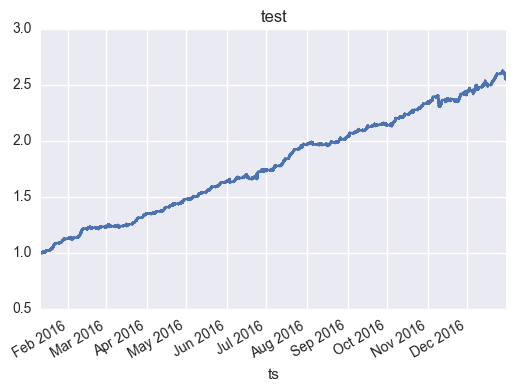

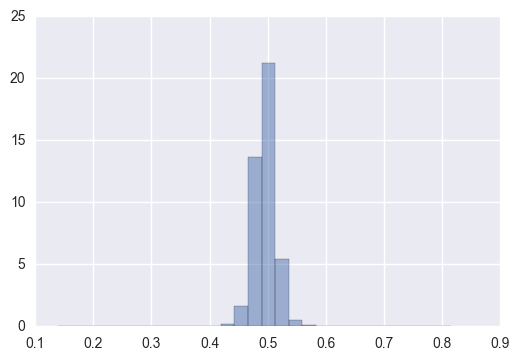

[[97551 74315]
 [91804 80757]]


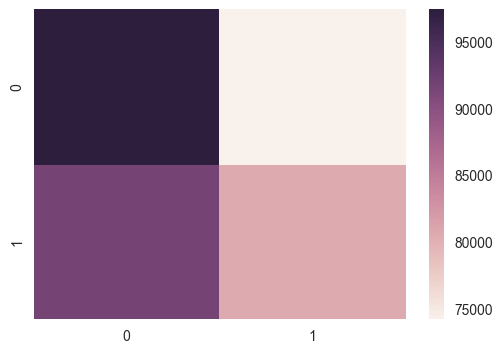

In [83]:
Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024)
metrics.performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred, cum_return_plot=True, histogram=True, heatmap=True)

-----------------------------------------


In [9]:
!! Idea: assess performance of 1 minute prediction over next n periods, e.g. by average signal, ewma signal.
    Versus predicting on n periods ahead directly.
    
    Increase N to point of being potentially tradeable.
    
    

IndentationError: unexpected indent (<ipython-input-9-a53d670d1814>, line 2)

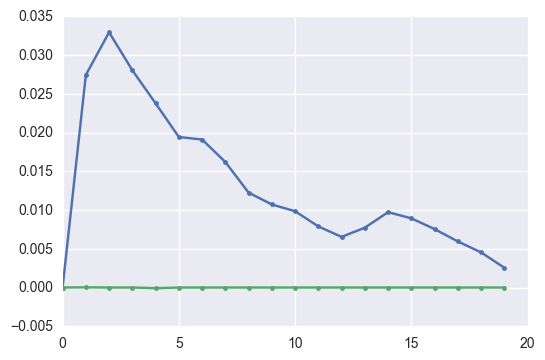

In [84]:
i_s = []
frsma = []
frewma = []
for i in range(20):
    i_s.append(i)
    fut_ret_sma = metrics.aggregated_predicted_future_return(
        prices=prices_test, prediction=Y_test_pred, agg_period=i, mode='sma').mean() *1e4
    frsma.append(fut_ret_sma)
    
    fut_ret_ewma = metrics.aggregated_predicted_future_return(
        prices=prices_test, prediction=Y_test_pred, agg_period=i, mode='ewm').mean() *1e4
    frewma.append(fut_ret_ewma)

plt.plot(i_s, frsma,'.-')
plt.plot(i_s, frewma,'.-')
    

??? why are perf charts below different to fut return charts from performance report.????

In [25]:
fut_return_test = utils.future_return(prices_test, 1)

In [26]:
def perf(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    cats = utils.prediction_to_category2(preds)
    # turn true/false into +1/-1
    signs = cats*2 -1 
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [27]:
def perf2(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = preds - 0.5
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [28]:
def perf3(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = (preds - 0.5)
    signs = np.tanh(signs/2)
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [29]:
print perf(Y_test_pred, fut_return_test).sum()
print perf2(Y_test_pred, fut_return_test).sum()
print perf3(Y_test_pred, fut_return_test).sum()

0.0122660329019
0.952012723526
0.00777558748553
1.68342089862
0.00778569398168
1.68030064559


0.0122660329019
0.00777558748553
0.00778569398168


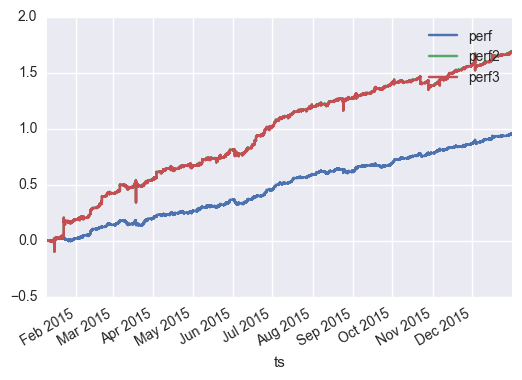

In [30]:
perf(Y_test_pred, fut_return_test).cumsum().plot(label='perf')
perf2(Y_test_pred, fut_return_test).cumsum().plot(label='perf2')
perf3(Y_test_pred, fut_return_test).cumsum().plot(label='perf3')
plt.legend()

-----------------------------------

## Control

In [64]:
X_control, Y_control, prices_control = datasets.prepare_dataset3(df=datasets.random_ohlc(100000),lookahead=1, n_periods=25)

In [65]:
X_test.describe()

,open-0,high-0,low-0,open-1,high-1,low-1,close-1,open-2,high-2,low-2,...,low-328,close-328,open-365,high-365,low-365,close-365,open-404,high-404,low-404,close-404
count,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,...,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000,344427.000000
mean,-0.000041,0.008480,-0.007924,-0.000047,0.008512,-0.007963,-0.000325,-0.000030,0.008550,-0.007986,...,-0.002222,-0.013370,-0.000336,-0.000733,0.001114,-0.014555,-0.000838,-0.005545,0.005429,-0.015714
std,1.009683,1.004912,1.006623,1.009681,1.004878,1.006608,1.009611,1.009647,1.004845,1.006532,...,1.004568,1.011331,1.003208,1.000110,1.003212,1.011205,0.999459,0.997828,0.999505,1.010876
min,-41.553018,-0.910675,-48.966994,-41.553018,-0.910675,-48.966994,-41.313353,-41.553018,-0.910675,-48.966994,...,-48.966994,-7.605419,-41.553018,-0.910675,-48.966994,-7.351079,-41.553018,-0.910675,-48.966994,-7.296327
25%,-0.405087,-0.604921,-0.281536,-0.405101,-0.604851,-0.281540,-0.412357,-0.405118,-0.604786,-0.281543,...,-0.271282,-0.530998,-0.398304,-0.607169,-0.265799,-0.542566,-0.396091,-0.608971,-0.259916,-0.561706
50%,-0.005384,-0.294773,0.285228,-0.005383,-0.294725,0.285137,-0.000810,-0.005378,-0.294701,0.285068,...,0.291777,-0.022598,-0.005394,-0.303060,0.295298,-0.023627,-0.005490,-0.306620,0.298502,-0.022770
75%,0.405339,0.284712,0.603451,0.405366,0.284719,0.603383,0.412551,0.405402,0.284725,0.603316,...,0.605477,0.491978,0.398222,0.269021,0.606728,0.499237,0.394824,0.262287,0.608240,0.508326
max,38.571715,46.178150,0.917845,38.571715,46.178150,0.917845,37.817848,38.571715,46.178150,0.917845,...,0.917845,8.763413,38.571715,46.178150,0.917845,7.960482,38.571715,46.178150,0.917845,7.944463


In [66]:
X_control.describe()

,open-0,high-0,low-0,open-1,high-1,low-1,close-1,open-2,high-2,low-2,...,low-328,close-328,open-365,high-365,low-365,close-365,open-404,high-404,low-404,close-404
count,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,...,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000
mean,-0.000088,-0.000211,-0.000440,-0.000112,-0.000245,-0.000465,-0.000194,-0.000122,-0.000245,-0.000470,...,0.000089,0.004855,0.000574,0.000434,0.000190,0.005491,0.000642,0.000515,0.000283,0.005706
std,0.999288,0.999299,0.999850,0.999270,0.999279,0.999855,0.999312,0.999277,0.999279,0.999859,...,0.999559,1.033740,0.999234,0.999423,0.999505,1.035877,0.999218,0.999512,0.999445,1.037690
min,-4.185255,-0.987454,-6.100036,-4.185255,-0.987454,-6.100036,-4.794631,-4.185255,-0.987454,-6.100036,...,-6.100036,-4.046714,-4.185255,-0.987454,-6.100036,-4.164943,-4.185255,-0.987454,-6.100036,-3.859917
25%,-0.676165,-0.943554,-0.580553,-0.676165,-0.943571,-0.580624,-0.676788,-0.676215,-0.943571,-0.580646,...,-0.579836,-0.701313,-0.675469,-0.943445,-0.579836,-0.714975,-0.675388,-0.943401,-0.579470,-0.734357
50%,0.001954,-0.252874,0.252507,0.001933,-0.252909,0.252466,-0.003525,0.001933,-0.252909,0.252466,...,0.252990,-0.030338,0.003008,-0.252025,0.253098,-0.028741,0.003008,-0.252050,0.253228,-0.012611
75%,0.672356,0.576421,0.954436,0.672331,0.576414,0.954433,0.673771,0.672331,0.576414,0.954433,...,0.954530,0.705383,0.673344,0.577677,0.954552,0.712064,0.673258,0.577870,0.954561,0.715399
max,4.431534,6.423538,0.990023,4.431534,6.423538,0.990023,4.446161,4.431534,6.423538,0.990023,...,0.990023,3.991014,4.431534,6.423538,0.990023,4.254214,4.431534,6.423538,0.990023,3.815221


control: f1-score: 0.499, mean future return: 0.000 bps


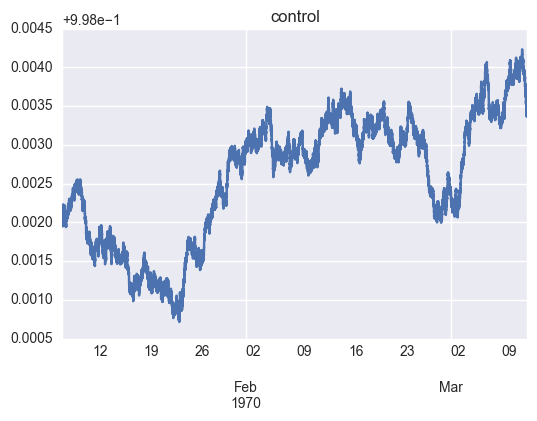

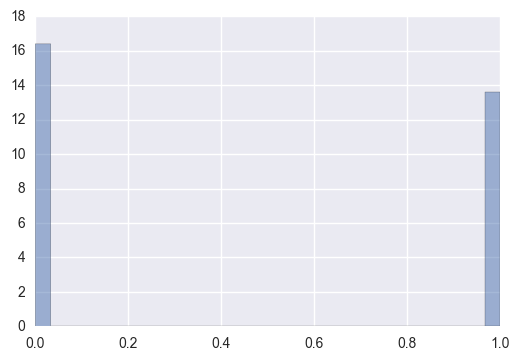

[[24945 20710]
 [25077 20786]]


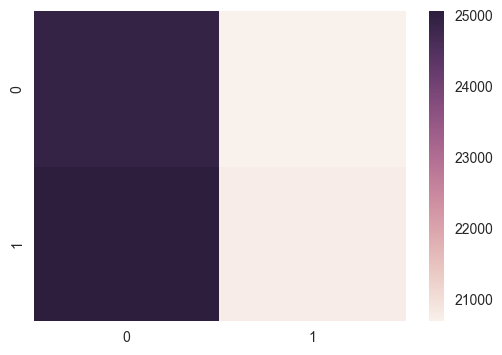

In [68]:
Y_control_pred = model.predict(X_control.as_matrix(), batch_size=1024)
Y_control_pred_class = utils.prediction_to_category2(Y_control_pred)
metrics.performance_report("control",  prices_control,  lookahead, Y_control, Y_control_pred_class, cum_return_plot=True, heatmap=True, histogram=True)

In [22]:
(fut_return_control.ix[~Y_control_pred_class[:,0]]+1).mean() - fut_return_control.mean() - 1

NameError: name 'fut_return_control' is not defined